In [1]:
import os
import pathlib
from PIL import Image

import IPython.display as display
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Softmax)
import tensorflow_hub as hub

# Exploring the data

In [2]:
data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
print("There are", image_count, "images.")

CLASS_NAMES = np.array(
    [item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
print("These are the available classes:", CLASS_NAMES)

There are 3670 images.
These are the available classes: ['daisy' 'dandelion' 'sunflowers' 'tulips' 'roses']


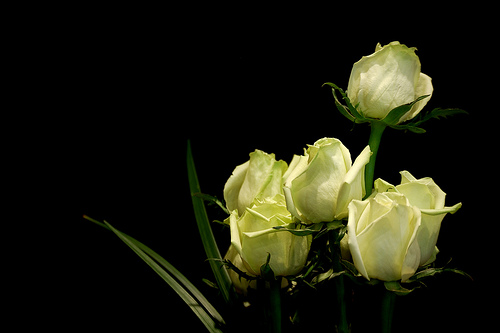

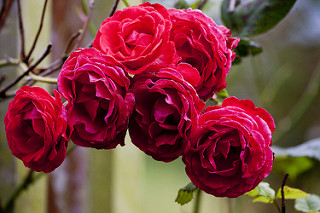

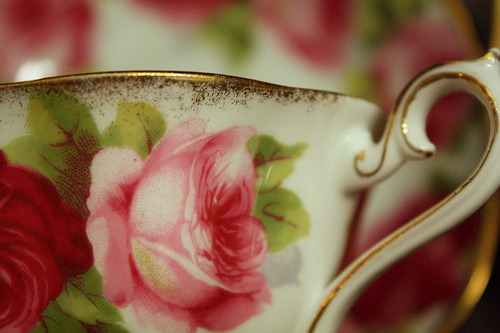

In [3]:
roses = list(data_dir.glob('roses/*'))

for image_path in roses[:3]:
    display.display(Image.open(str(image_path)))

In [9]:
!gsutil cat gs://cloud-ml-data/img/flower_photos/train_set.csv \
    | head -5 > /tmp/input.csv
!cat /tmp/input.csv
!gsutil cat gs://cloud-ml-data/img/flower_photos/train_set.csv | \
    sed 's/,/ /g' | awk '{print $2}' | sort | uniq > /tmp/labels.txt
!cat /tmp/labels.txt

gs://cloud-ml-data/img/flower_photos/daisy/754296579_30a9ae018c_n.jpg,daisy
gs://cloud-ml-data/img/flower_photos/dandelion/18089878729_907ed2c7cd_m.jpg,dandelion
gs://cloud-ml-data/img/flower_photos/dandelion/284497199_93a01f48f6.jpg,dandelion
gs://cloud-ml-data/img/flower_photos/dandelion/3554992110_81d8c9b0bd_m.jpg,dandelion
gs://cloud-ml-data/img/flower_photos/daisy/4065883015_4bb6010cb7_n.jpg,daisy
daisy
dandelion
roses
sunflowers
tulips


# Building the dataset

In [8]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

BATCH_SIZE = 32
# 10 is a magic number tuned for local training of this dataset.
SHUFFLE_BUFFER = 10 * BATCH_SIZE
AUTOTUNE = tf.data.experimental.AUTOTUNE

VALIDATION_IMAGES = 370
VALIDATION_STEPS = VALIDATION_IMAGES // BATCH_SIZE

In [7]:
def decode_img(img, reshape_dims):
    # Convert the compressed string to a 3D uint8 tensor.
    img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Resize the image to the desired size.
    return tf.image.resize(img, reshape_dims)

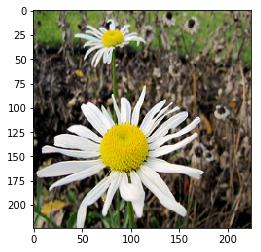

In [11]:
img = tf.io.read_file(
    "gs://cloud-ml-data/img/flower_photos/daisy/4065883015_4bb6010cb7_n.jpg")

# Uncomment to see the image string.
#print(img)
img = decode_img(img, [IMG_WIDTH, IMG_HEIGHT])
plt.imshow((img.numpy()));

In [12]:
def decode_csv(csv_row):
    record_defaults = ["path", "flower"]
    filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
    image_bytes = tf.io.read_file(filename=filename)
    label = tf.math.equal(CLASS_NAMES, label_string)
    return image_bytes, label

# Image Augementation

In [13]:
MAX_DELTA = 63.0 / 255.0  # Change brightness by at most 17.7%
CONTRAST_LOWER = 0.2
CONTRAST_UPPER = 1.8

def read_and_preprocess(image_bytes, label, random_augment=False):
    if random_augment:
        img = decode_img(image_bytes, [IMG_HEIGHT + 10, IMG_WIDTH + 10])
        img = tf.image.random_crop(img, [IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, MAX_DELTA)
        img = tf.image.random_contrast(img, CONTRAST_LOWER, CONTRAST_UPPER)
    else:
        img = decode_img(image_bytes, [IMG_WIDTH, IMG_HEIGHT])
    return img, label


def read_and_preprocess_with_augment(image_bytes, label):
    return read_and_preprocess(image_bytes, label, random_augment=True)

In [14]:
def load_dataset(csv_of_filenames, batch_size, training=True):
    dataset = tf.data.TextLineDataset(filenames=csv_of_filenames) \
        .map(decode_csv).cache()

    if training:
        dataset = dataset \
            .map(read_and_preprocess_with_augment) \
            .shuffle(SHUFFLE_BUFFER) \
            .repeat(count=None)  # Indefinately.
    else:
        dataset = dataset \
            .map(read_and_preprocess) \
            .repeat(count=1)  # Each photo used once.

    # Prefetch prepares the next set of batches while current batch is in use.
    return dataset.batch(batch_size=batch_size).prefetch(buffer_size=AUTOTUNE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor([False False False False  True], shape=(5,), dtype=bool)


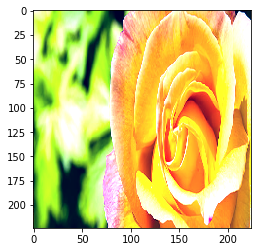

In [17]:
train_path = "gs://cloud-ml-data/img/flower_photos/train_set.csv"
train_data = load_dataset(train_path, 1)
itr = iter(train_data)
image_batch, label_batch = next(itr)
img = image_batch[0]
plt.imshow(img)
print(label_batch[0])

In [20]:
eval_path = "gs://cloud-ml-data/img/flower_photos/eval_set.csv"
nclasses = len(CLASS_NAMES)
hidden_layer_1_neurons = 400
hidden_layer_2_neurons = 100
dropout_rate = 0.25
num_filters_1 = 64
kernel_size_1 = 3
pooling_size_1 = 2
num_filters_2 = 32
kernel_size_2 = 3
pooling_size_2 = 2

layers = [
    Conv2D(num_filters_1, kernel_size=kernel_size_1,
           activation='relu',
           input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)),
    MaxPooling2D(pooling_size_1),
    Conv2D(num_filters_2, kernel_size=kernel_size_2,
           activation='relu'),
    MaxPooling2D(pooling_size_2),
    Flatten(),
    Dense(hidden_layer_1_neurons, activation='relu'),
    Dense(hidden_layer_2_neurons, activation='relu'),
    Dropout(dropout_rate),
    Dense(nclasses),
    Softmax()
]

old_model = Sequential(layers)

old_model.build((None,)+(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
old_model.summary()

old_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

train_ds = load_dataset(train_path, BATCH_SIZE)
eval_ds = load_dataset(eval_path, BATCH_SIZE, training=False)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 109, 109, 32)      18464     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 93312)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 400)               37325200  
_________________________________________________________________
dense_7 (Dense)              (None, 100)              

In [21]:
old_model.fit_generator(
    train_ds,
    epochs=5,
    steps_per_epoch=5,
    validation_data=eval_ds,
    validation_steps=VALIDATION_STEPS
)

Epoch 1/5
5/5 [==============================] - 57s 11s/step - loss: 2.7248 - accuracy: 0.1750 - val_loss: 1.5956 - val_accuracy: 0.2443
Epoch 2/5
5/5 [==============================] - 11s 2s/step - loss: 1.5894 - accuracy: 0.2500 - val_loss: 1.5304 - val_accuracy: 0.1705
Epoch 3/5
5/5 [==============================] - 12s 2s/step - loss: 1.4848 - accuracy: 0.2625 - val_loss: 1.4923 - val_accuracy: 0.3011
Epoch 4/5
5/5 [==============================] - 12s 2s/step - loss: 1.5019 - accuracy: 0.2812 - val_loss: 1.4876 - val_accuracy: 0.3778
Epoch 5/5
5/5 [==============================] - 12s 2s/step - loss: 1.5385 - accuracy: 0.3125 - val_loss: 1.4528 - val_accuracy: 0.4119
